In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=8)

In [17]:
df = pd.read_csv('i5 - 9 gen/dataset_i5-9gen_with_cycles.csv', index_col=False)
df['amd']=0
df

,workload,cycles,cache-misses,instructions,cycle_activity.stalls_total,branch-misses,context-switches,iTLB-load-misses,IpCall,IpLoad,IpMispredict,BpTkBranch,MLP,amd
0,500.perlbench_r,8161831361,25741624,19244473297,1661700474,34112016,11,240354,98.45,3.64,439.30,2.03,1.39,0
1,500.perlbench_r,16524592463,51543983,39867315327,3238937052,74501671,19,395540,108.91,3.65,400.45,2.05,1.36,0
2,500.perlbench_r,24845507433,78831602,60442673577,4837212858,114823505,34,552608,112.42,3.65,389.37,2.06,1.35,0
3,500.perlbench_r,33099307131,104275450,81237734926,6379915775,155716591,42,705694,114.11,3.65,383.99,2.07,1.35,0
4,500.perlbench_r,41358873306,130200148,101910825510,7948209890,195524777,50,868384,115.31,3.65,399.80,2.07,1.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,554.roms_r,1806493514121,73615936564,1398024373244,1026184222415,177320584,2739,1499003,220.94,2.11,7993.82,1.31,4.61,0
4826,554.roms_r,1815268744457,73973130083,1404687079653,1031222974741,178269068,2753,1501838,220.79,2.11,7995.23,1.31,4.61,0
4827,554.roms_r,1824041720183,74321864813,1411754359980,1036107102054,179163699,2768,1506076,220.95,2.11,7993.38,1.31,4.61,0
4828,554.roms_r,1832819334257,74687181297,1417970975697,1041283979037,180007925,2784,1508837,220.76,2.11,7990.79,1.31,4.61,0


In [18]:
df.columns
#cycle_activity.stalls_total == stalled-cycles-backend
#IpCall == IpNreturn

Index(['workload', 'cycles', 'cache-misses', 'instructions',
       'cycle_activity.stalls_total', 'branch-misses', 'context-switches',
       'iTLB-load-misses', 'IpCall', 'IpLoad', 'IpMispredict', 'BpTkBranch',
       'MLP', 'amd'],
      dtype='object')

In [19]:
workloads={
    '500.perlbench_r':0,
    '502.gcc_r':1,
    '505.mcf_r':2,
    '507.cactuBSSN_r':3,
    '508.namd_r':4,
    '510.parest_r':5,
    '511.povray_r':6,
    '519.lbm_r':7,
    '520.omnetpp_r':8,
    '523.xalancmbk_r':9,
    '525.x264_r':10,
    '526.blender_r':11,
    '531.deepsjeng_r':12,
    '538.imagick_r':13,
    '541.leela_r':14,
    '544.nab_r':15,
    '548.exchange2_r':16,
    '549.fotonik3d_r':17,
    '554.roms_r':18,
    '557.xz_r':19
}
df['wkld']=df['workload']
df=pd.get_dummies(df, columns=['wkld'])
df['workload']=df['workload'].astype('category').map(workloads)
df=df.drop(['IpLoad', 'MLP'], axis=1)
df

,workload,cycles,cache-misses,instructions,cycle_activity.stalls_total,branch-misses,context-switches,iTLB-load-misses,IpCall,IpMispredict,...,wkld_526.blender_r,wkld_527.cam4_r,wkld_531.deepsjeng_r,wkld_538.imagick_r,wkld_541.leela_r,wkld_544.nab_r,wkld_548.exchange2_r,wkld_549.fotonik3d_r,wkld_554.roms_r,wkld_557.xz_r
0,0.0,8161831361,25741624,19244473297,1661700474,34112016,11,240354,98.45,439.30,...,0,0,0,0,0,0,0,0,0,0
1,0.0,16524592463,51543983,39867315327,3238937052,74501671,19,395540,108.91,400.45,...,0,0,0,0,0,0,0,0,0,0
2,0.0,24845507433,78831602,60442673577,4837212858,114823505,34,552608,112.42,389.37,...,0,0,0,0,0,0,0,0,0,0
3,0.0,33099307131,104275450,81237734926,6379915775,155716591,42,705694,114.11,383.99,...,0,0,0,0,0,0,0,0,0,0
4,0.0,41358873306,130200148,101910825510,7948209890,195524777,50,868384,115.31,399.80,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,18.0,1806493514121,73615936564,1398024373244,1026184222415,177320584,2739,1499003,220.94,7993.82,...,0,0,0,0,0,0,0,0,1,0
4826,18.0,1815268744457,73973130083,1404687079653,1031222974741,178269068,2753,1501838,220.79,7995.23,...,0,0,0,0,0,0,0,0,1,0
4827,18.0,1824041720183,74321864813,1411754359980,1036107102054,179163699,2768,1506076,220.95,7993.38,...,0,0,0,0,0,0,0,0,1,0
4828,18.0,1832819334257,74687181297,1417970975697,1041283979037,180007925,2784,1508837,220.76,7990.79,...,0,0,0,0,0,0,0,0,1,0


In [20]:
df.columns

Index(['workload', 'cycles', 'cache-misses', 'instructions',
       'cycle_activity.stalls_total', 'branch-misses', 'context-switches',
       'iTLB-load-misses', 'IpCall', 'IpMispredict', 'BpTkBranch', 'amd',
       'wkld_500.perlbench_r', 'wkld_502.gcc_r', 'wkld_503.bwaves_r',
       'wkld_505.mcf_r', 'wkld_507.cactuBSSN_r', 'wkld_508.namd_r',
       'wkld_510.parest_r', 'wkld_511.povray_r', 'wkld_519.lbm_r',
       'wkld_520.omnetpp_r', 'wkld_521.wrf_r', 'wkld_523.xalancmbk_r',
       'wkld_525.x264_r', 'wkld_526.blender_r', 'wkld_527.cam4_r',
       'wkld_531.deepsjeng_r', 'wkld_538.imagick_r', 'wkld_541.leela_r',
       'wkld_544.nab_r', 'wkld_548.exchange2_r', 'wkld_549.fotonik3d_r',
       'wkld_554.roms_r', 'wkld_557.xz_r'],
      dtype='object')

In [21]:
wkll=['500.perlbench_r', '502.gcc_r', '505.mcf_r', '507.cactuBSSN_r', '508.namd_r', '510.parest_r', '511.povray_r', '519.lbm_r', '520.omnetpp_r', '523.xalancmbk_r', '525.x264_r', '526.blender_r', '531.deepsjeng_r', '538.imagick_r', '541.leela_r', '544.nab_r', '548.exchange2_r', '549.fotonik3d_r', '554.roms_r', '557.xz_r']

In [22]:
# Separating features and target into numpy arrays

X=np.array(df.loc[:, 'cache-misses':'BpTkBranch'])
y=np.array(df['cycles']).reshape(-1, 1)

In [23]:
models = ['LR', 'DT', 'RF', 'XGB', 'KNN', 'MLP']
estimator = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(), KNeighborsRegressor(),
             MLPRegressor(max_iter=300)]

In [24]:
df7 = pd.read_csv('AMD/dataset_AMD_with_cycles.csv', index_col=False)
df7['amd']=1
df7

,workload,cycles,cache-misses,instructions,stalled-cycles-backend,branch-misses,context-switches,iTLB-load-misses,IpNReturn,IpMispredict,BpTkBranch,amd
0,500.perlbench_r,8028421320,34676176,17425802999,2212562039,27662841,204,23689,98.04,630.04,2.03,1
1,500.perlbench_r,16087947993,74224914,36278186263,4492444234,61126746,408,43264,108.63,594.33,2.06,1
2,500.perlbench_r,24162112688,113822120,55101104017,6774157036,94435057,611,63211,112.39,583.75,2.07,1
3,500.perlbench_r,32236497230,153887810,73831200642,9065279787,127814719,811,83729,114.30,578.29,2.08,1
4,500.perlbench_r,40311057083,189852029,93027475737,11315314195,160465979,1009,102081,115.50,580.23,2.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4825,554.roms_r,1659705493089,23218844161,1382266432073,1338682681299,158250778,40689,45818,226.79,8746.47,1.30,1
4826,554.roms_r,1667775281187,23331339227,1389010545617,1345258634545,159033666,40883,45861,226.77,8746.61,1.30,1
4827,554.roms_r,1675844281461,23440652298,1396216719898,1351701610135,159868555,41084,45901,226.62,8747.44,1.30,1
4828,554.roms_r,1683890594406,23555667347,1402381359034,1358259478920,160596172,41283,46200,226.74,8746.36,1.30,1


In [25]:
df7['wkld']=df7['workload']
df7=pd.get_dummies(df7, columns=['wkld'])
df7['workload']=df7['workload'].astype('category').map(workloads)
df7

,workload,cycles,cache-misses,instructions,stalled-cycles-backend,branch-misses,context-switches,iTLB-load-misses,IpNReturn,IpMispredict,...,wkld_526.blender_r,wkld_527.cam4_r,wkld_531.deepsjeng_r,wkld_538.imagick_r,wkld_541.leela_r,wkld_544.nab_r,wkld_548.exchange2_r,wkld_549.fotonik3d_r,wkld_554.roms_r,wkld_557.xz_r
0,0.0,8028421320,34676176,17425802999,2212562039,27662841,204,23689,98.04,630.04,...,0,0,0,0,0,0,0,0,0,0
1,0.0,16087947993,74224914,36278186263,4492444234,61126746,408,43264,108.63,594.33,...,0,0,0,0,0,0,0,0,0,0
2,0.0,24162112688,113822120,55101104017,6774157036,94435057,611,63211,112.39,583.75,...,0,0,0,0,0,0,0,0,0,0
3,0.0,32236497230,153887810,73831200642,9065279787,127814719,811,83729,114.30,578.29,...,0,0,0,0,0,0,0,0,0,0
4,0.0,40311057083,189852029,93027475737,11315314195,160465979,1009,102081,115.50,580.23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,18.0,1659705493089,23218844161,1382266432073,1338682681299,158250778,40689,45818,226.79,8746.47,...,0,0,0,0,0,0,0,0,1,0
4826,18.0,1667775281187,23331339227,1389010545617,1345258634545,159033666,40883,45861,226.77,8746.61,...,0,0,0,0,0,0,0,0,1,0
4827,18.0,1675844281461,23440652298,1396216719898,1351701610135,159868555,41084,45901,226.62,8747.44,...,0,0,0,0,0,0,0,0,1,0
4828,18.0,1683890594406,23555667347,1402381359034,1358259478920,160596172,41283,46200,226.74,8746.36,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df7.columns

Index(['workload', 'cycles', 'cache-misses', 'instructions',
       'stalled-cycles-backend', 'branch-misses', 'context-switches',
       'iTLB-load-misses', 'IpNReturn', 'IpMispredict', 'BpTkBranch', 'amd',
       'wkld_500.perlbench_r', 'wkld_502.gcc_r', 'wkld_503.bwaves_r',
       'wkld_505.mcf_r', 'wkld_507.cactuBSSN_r', 'wkld_508.namd_r',
       'wkld_510.parest_r', 'wkld_511.povray_r', 'wkld_519.lbm_r',
       'wkld_520.omnetpp_r', 'wkld_521.wrf_r', 'wkld_523.xalancmbk_r',
       'wkld_525.x264_r', 'wkld_526.blender_r', 'wkld_527.cam4_r',
       'wkld_531.deepsjeng_r', 'wkld_538.imagick_r', 'wkld_541.leela_r',
       'wkld_544.nab_r', 'wkld_548.exchange2_r', 'wkld_549.fotonik3d_r',
       'wkld_554.roms_r', 'wkld_557.xz_r'],
      dtype='object')

In [28]:
# Separating features and target into numpy arrays

X7=np.array(df.loc[:, 'cache-misses':'BpTkBranch'])
y7=np.array(df['cycles']).reshape(-1, 1)

In [29]:
X75 = np.concatenate((X, X7))
X75.shape

(9660, 9)

Axis  Variance covered by PCA:
  1       23.769935
  2       20.765818
  3       16.713588
  4       12.393182
  5       11.150186
  6        7.749769
  7        5.532856
  8        1.560805


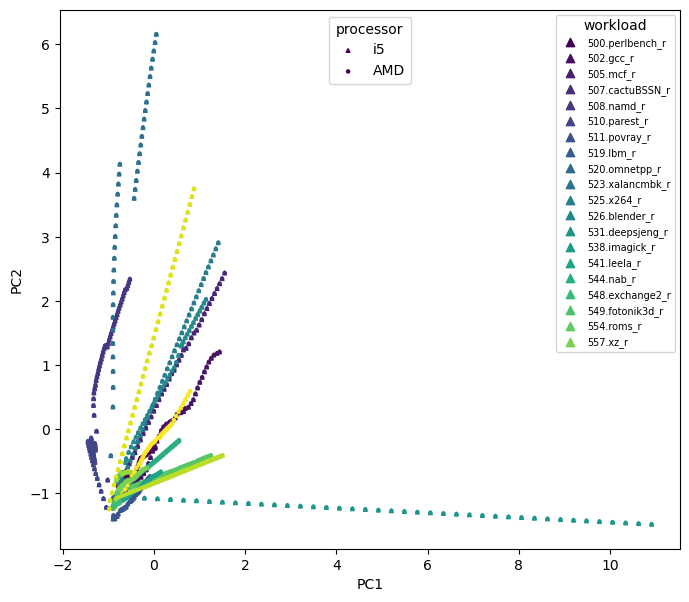

In [83]:
# Principal Component Analysis of i5 & AMD combined datasets

scaler = StandardScaler().fit(X75)
X75sc = scaler.transform(X75)          # Z-transform all column values
pca=PCA(n_components=X75.shape[1])
pca.fit(X75sc)
X75_pca=pca.transform(X75sc)
print("Axis  Variance covered by PCA:")
for i in range(8): print('%3d %15f'%(i+1, pca.explained_variance_ratio_[i]*100))
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
scatter1=ax.scatter(X75_pca[:4830:5, 0], X75_pca[:4830:5, 1], 7, list(df['workload'])[::5], '^')
scatter2=ax.scatter(X75_pca[4830::5, 0], X75_pca[4830::5, 1], 5, list(df['workload'])[::5], 'o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
leg1 = ax.legend(handles=scatter1.legend_elements(num=23)[0], labels=workloads.keys(), title="workload", prop={'size': 7})
leg2 = ax.legend([scatter1,scatter2],['i5','AMD'], title="processor", loc='upper center')
ax.add_artist(leg1)

In [111]:
# Train on i5 + 'x' rows of AMD, test on remaining AMD
lo, hi, jmp = 0, 201, 10             # training size range
iters = (hi-lo-1)//jmp + 1
score = np.zeros((iters, len(models)))
mae = np.zeros((iters, len(models)))
mse = np.zeros((iters, len(models)))
indices = np.arange(X7.shape[0])
train_idx, test_idx = np.zeros((0), dtype=np.int8), indices
for trs in range(iters):
    if trs > 0:
        trainpool_idx, test_idx = train_test_split(test_idx, train_size=jmp)
        train_idx = np.concatenate((train_idx, trainpool_idx))
    X75_train, y75_train = np.concatenate((X, X7[train_idx])), np.concatenate((y, y7[train_idx]))
    X7_test, y7_test = X7[test_idx], y7[test_idx]
    X_scaler, y_scaler = StandardScaler().fit(X75_train), StandardScaler().fit(y75_train)
    X75_train = np.concatenate((X_scaler.transform(X75_train), np.concatenate((df.iloc[:,-24:], df7.iloc[train_idx,-24:]))), axis=1)
    X7_test   = np.concatenate((X_scaler.transform(X7_test)  , df7.iloc[test_idx,-24:]), axis=1)
    y75_train, y7_test = y_scaler.transform(y75_train), y_scaler.transform(y7_test)
    print(X75_train.shape[0], X7_test.shape[0])
    
    for model in range(len(models)):
        e = estimator[model].fit(X75_train, y75_train.ravel())
        score[trs][model] = e.score(X7_test, y7_test)
        y_pred = e.predict(X7_test)
        mae[trs][model] = mean_absolute_error(y_true=y7_test, y_pred=y_pred)
        mse[trs][model] = mean_squared_error(y_true=y7_test, y_pred=y_pred)

4830 4830
4840 4820
4850 4810
4860 4800
4870 4790
4880 4780
4890 4770
4900 4760
4910 4750
4920 4740
4930 4730
4940 4720
4950 4710
4960 4700
4970 4690
4980 4680
4990 4670
5000 4660
5010 4650
5020 4640
5030 4630


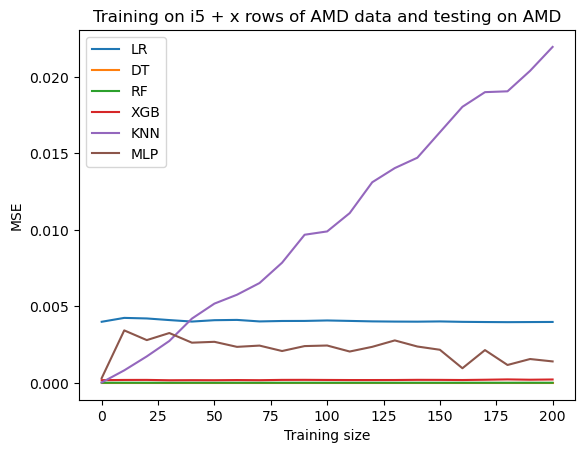

In [112]:
l=0
for model in range(5):
    plt.plot(range(l, hi, jmp), mse[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), mse[l//10:, 5], label=models[5])
plt.legend()
plt.title('Training on i5 + x rows of AMD data and testing on AMD')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.show()

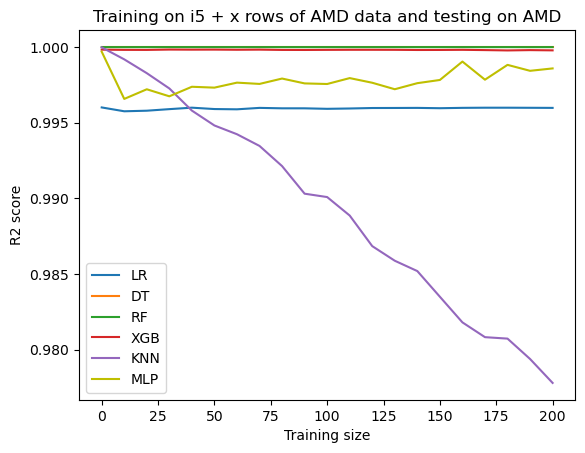

In [113]:
for model in range(5):
    plt.plot(range(l, hi, jmp), score[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), score[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on i5 + x rows of AMD data and testing on AMD')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

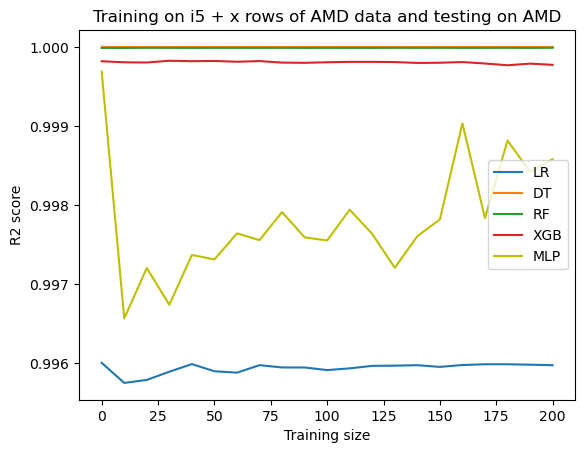

In [114]:
for model in range(4):
    plt.plot(range(l, hi, jmp), score[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), score[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on i5 + x rows of AMD data and testing on AMD')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

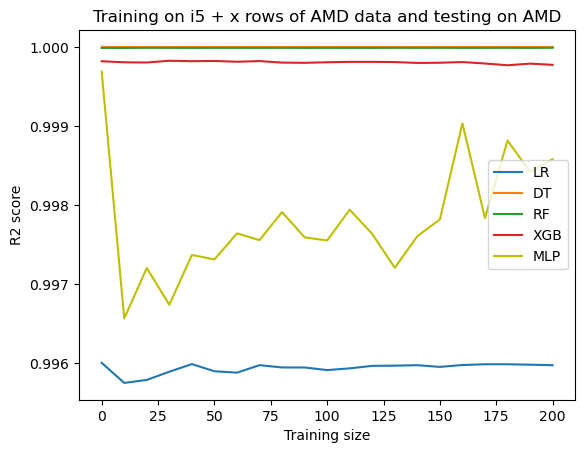

In [115]:
for model in range(4):
    plt.plot(range(l, hi, jmp), score[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), score[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on i5 + x rows of AMD data and testing on AMD')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

In [130]:
pd.DataFrame(score[:10,5], range(lo, 51, jmp))

,0
5,0.999685
10,0.996565
15,0.997202
20,0.996738
25,0.997368
30,0.997310
35,0.997641
40,0.997555
45,0.997911
50,0.997590


In [129]:
score[:10,5]

array([0.99968549, 0.99656538, 0.99720188, 0.99673757, 0.99736786,
       0.99731036, 0.99764096, 0.99755546, 0.99791068, 0.99758996])

In [68]:
# Train on AMD + 'x' rows of i5 test on remaining i5
lo, hi, jmp = 0, 201, 10             # training size range
iters = (hi-lo-1)//jmp + 1
score1 = np.zeros((iters, len(models)))
mae1 = np.zeros((iters, len(models)))
mse1 = np.zeros((iters, len(models)))
indices = np.arange(X.shape[0])
train_idx, test_idx = np.zeros((0), dtype=np.int8), indices
for trs in range(iters):
    if trs > 0:
        trainpool_idx, test_idx = train_test_split(test_idx, train_size=jmp)
        train_idx = np.concatenate((train_idx, trainpool_idx))
    X57_train, y57_train = np.concatenate((X7, X[train_idx])), np.concatenate((y7, y[train_idx]))
    X_test, y_test = X[test_idx], y[test_idx]
    X_scaler, y_scaler = StandardScaler().fit(X57_train), StandardScaler().fit(y57_train)
    X57_train = np.concatenate((X_scaler.transform(X57_train), np.concatenate((df.iloc[:,-24:], df.iloc[train_idx,-24:]))), axis=1)
    X_test    = np.concatenate((X_scaler.transform(X_test)  , df.iloc[test_idx,-24:]), axis=1)
    y57_train, y_test = y_scaler.transform(y57_train), y_scaler.transform(y_test)
    print(X57_train.shape[0], X_test.shape[0])
    
    for model in range(len(models)):
        e = estimator[model].fit(X57_train, y57_train.ravel())
        score1[trs][model] = e.score(X_test, y_test)
        y_pred = e.predict(X_test)
        mae1[trs][model] = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        mse1[trs][model] = mean_squared_error(y_true=y_test, y_pred=y_pred)

4830 4830
4840 4820
4850 4810
4860 4800
4870 4790
4880 4780
4890 4770
4900 4760
4910 4750
4920 4740
4930 4730
4940 4720
4950 4710
4960 4700
4970 4690
4980 4680
4990 4670
5000 4660
5010 4650
5020 4640
5030 4630


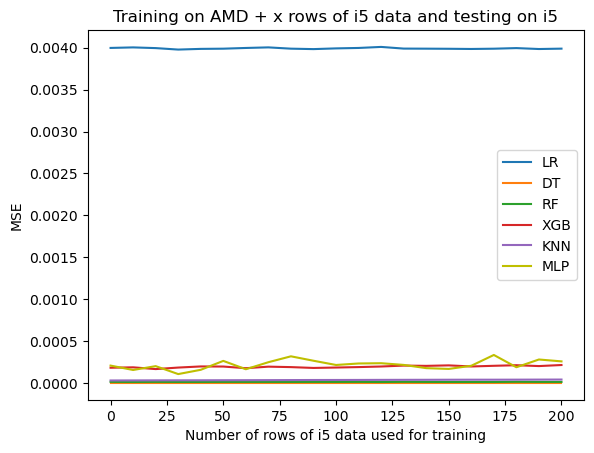

In [70]:
l=0
for model in range(5):
    plt.plot(range(l, hi, jmp), mse1[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), mse1[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on AMD + x rows of i5 data and testing on i5')
plt.xlabel('Number of rows of i5 data used for training')
plt.ylabel('MSE')
plt.show()

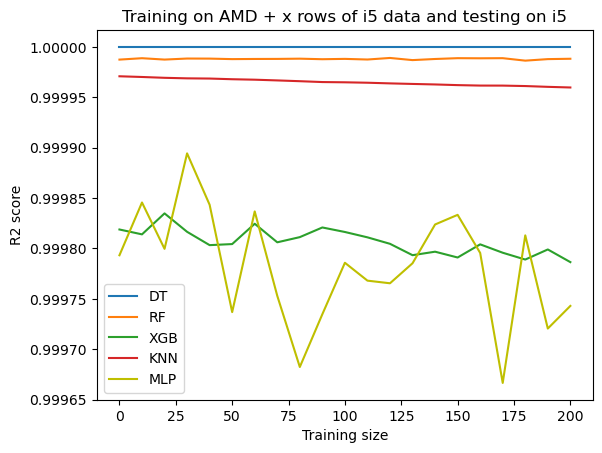

In [105]:
l=0
hi=201
jmp=10
for model in range(1, 5):
    plt.plot(range(l, hi, jmp), score1[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), score1[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on AMD + x rows of i5 data and testing on i5')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

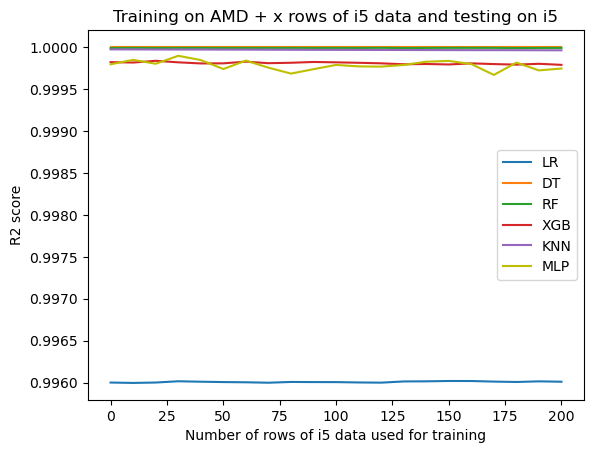

In [84]:
for model in range(5):
    plt.plot(range(l, hi, jmp), score1[l//10:, model], label=models[model])
plt.plot(range(l, hi, jmp), score1[l//10:, 5], label=models[5], color='y')
plt.legend()
plt.title('Training on AMD + x rows of i5 data and testing on i5')
plt.xlabel('Number of rows of i5 data used for training')
plt.ylabel('R2 score')
plt.show()

In [82]:
pd.Series(estimator[1].feature_importances_, df.columns[2:])

cache-misses                   5.125086e-03
instructions                   5.840102e-01
cycle_activity.stalls_total    1.558583e-01
branch-misses                  5.249430e-03
context-switches               2.149259e-01
iTLB-load-misses               1.040005e-03
IpCall                         3.526589e-03
IpMispredict                   5.947100e-03
BpTkBranch                     2.379204e-02
amd                            0.000000e+00
wkld_500.perlbench_r           9.471799e-08
wkld_502.gcc_r                 8.344620e-08
wkld_503.bwaves_r              8.032455e-07
wkld_505.mcf_r                 3.229303e-07
wkld_507.cactuBSSN_r           4.872970e-07
wkld_508.namd_r                1.494558e-08
wkld_510.parest_r              7.777842e-10
wkld_511.povray_r              4.489361e-08
wkld_519.lbm_r                 8.386705e-09
wkld_520.omnetpp_r             1.109709e-07
wkld_521.wrf_r                 7.796588e-08
wkld_523.xalancmbk_r           1.073779e-04
wkld_525.x264_r                2

In [30]:
score1[:10, 5]    # 80 rows for MLP

array([0.58028235, 0.51682927, 0.87510197, 0.93373977, 0.83227721,
       0.94549762, 0.93611201, 0.9695976 , 0.95759383, 0.96065869])

In [124]:
# Train on i5 (for cross only) + 'x' rows of AMD, test on remaining AMD for MLP
lo, hi, jmp = 5, 201, 5             # training size range
iters = (hi-lo-1)//jmp + 1
score75 = np.zeros((iters, 2))    # 0=self, 1=cross
mae75 = np.zeros((iters, 2))
mse75 = np.zeros((iters, 2))

indices = np.arange(X7.shape[0])
train_idx, test_idx = np.zeros((0), dtype=np.int8), indices
for trs in range(iters):
    trainpool_idx, test_idx = train_test_split(test_idx, train_size=jmp)
    train_idx = np.concatenate((train_idx, trainpool_idx))
    X75_train, y75_train = np.concatenate((X, X7[train_idx])), np.concatenate((y, y7[train_idx]))
    X75_test, y75_test = X7[test_idx], y7[test_idx]
    X_scaler, y_scaler = StandardScaler().fit(X75_train), StandardScaler().fit(y75_train)
    X75_train = np.concatenate((X_scaler.transform(X75_train), np.concatenate((df.iloc[:,-24:], df7.iloc[train_idx,-24:]))), axis=1)
    X75_test   = np.concatenate((X_scaler.transform(X75_test)  , df7.iloc[test_idx,-24:]), axis=1)
    y75_train, y75_test = y_scaler.transform(y75_train), y_scaler.transform(y75_test)
    
    X7_train, y7_train = X7[train_idx], y7[train_idx]
    X7_test, y7_test = X7[test_idx], y7[test_idx]          #same as X75_test and y75_test but made because of different scaling
    X_scaler, y_scaler = StandardScaler().fit(X7_train), StandardScaler().fit(y7_train)
    X7_train   = np.concatenate((X_scaler.transform(X7_train), df7.iloc[train_idx,-24:]), axis=1)
    X7_test   = np.concatenate((X_scaler.transform(X7_test)  , df7.iloc[test_idx,-24:]), axis=1)
    y7_train, y7_test = y_scaler.transform(y7_train), y_scaler.transform(y7_test)
    print(X75_train.shape[0], X7_train.shape[0], X75_test.shape[0])

    e0 = estimator[5].fit(X7_train, y7_train.ravel())      #self
    e1 = estimator[5].fit(X75_train, y75_train.ravel())    #cross
    score75[trs][0] = e0.score(X7_test, y7_test)
    score75[trs][1] = e1.score(X75_test, y75_test)
    y7_pred, y75_pred = e0.predict(X7_test), e1.predict(X75_test)
    mae75[trs][0] = mean_absolute_error(y_true=y7_test, y_pred=y7_pred)
    mse75[trs][0] = mean_squared_error(y_true=y7_test, y_pred=y7_pred)
    mae75[trs][1] = mean_absolute_error(y_true=y75_test, y_pred=y75_pred)
    mse75[trs][1] = mean_squared_error(y_true=y75_test, y_pred=y75_pred)

4835 5 4825
4840 10 4820
4845 15 4815
4850 20 4810
4855 25 4805
4860 30 4800
4865 35 4795
4870 40 4790
4875 45 4785
4880 50 4780
4885 55 4775
4890 60 4770
4895 65 4765
4900 70 4760
4905 75 4755
4910 80 4750
4915 85 4745
4920 90 4740
4925 95 4735
4930 100 4730
4935 105 4725
4940 110 4720
4945 115 4715
4950 120 4710
4955 125 4705
4960 130 4700
4965 135 4695
4970 140 4690
4975 145 4685
4980 150 4680
4985 155 4675
4990 160 4670
4995 165 4665
5000 170 4660
5005 175 4655
5010 180 4650
5015 185 4645
5020 190 4640
5025 195 4635
5030 200 4630


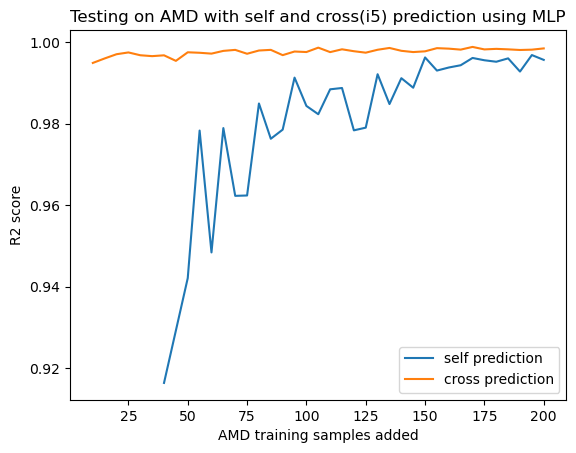

In [127]:
s=40
c=10
plt.plot(range(s, hi, jmp), score75[s//jmp-1:, 0], label='self prediction')
plt.plot(range(c, hi, jmp), score75[c//jmp-1:, 1], label='cross prediction')
plt.legend()
plt.title('Testing on AMD with self and cross(i5) prediction using MLP')
plt.xlabel('AMD training samples added')
plt.ylabel('R2 score')
plt.show()

In [126]:
score75[:10, 1]

array([0.99006537, 0.99493361, 0.99603892, 0.99707589, 0.99751392,
       0.99682216, 0.99660362, 0.99680517, 0.99544413, 0.99754964])